# With Dec=5e-10, and others with Andrew's value, add a tanh500 funtion on conductivity to check effect of 

In [50]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;
from scipy.io import savemat,loadmat;from pybamm import constants,exp,tanh,sqrt;import matplotlib as mpl;  # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import traceback
import imageio.v2 as imageio
fs=17;
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [51]:
# DEFINE my callback:
class RioCallback(pybamm.callbacks.Callback):
    def __init__(self, logfile=None):
        self.logfile = logfile
        self.success  = True
        if logfile is None:
            # Use pybamm's logger, which prints to command line
            self.logger = pybamm.logger
        else:
            # Use a custom logger, this will have its own level so set it to the same
            # level as the pybamm logger (users can override this)
            self.logger = pybamm.get_new_logger(__name__, logfile)
            self.logger.setLevel(pybamm.logger.level)
    
    def on_experiment_error(self, logs):
        self.success  = False
    def on_experiment_infeasible(self, logs):
        self.success  = False

In [52]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
)

In [53]:
def electrolyte_conductivity_Valoen2005Constant_wEC(c_e,c_EC, T):# Mark Ruihe change
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    a=1.092; b=-6.497e-6; c=-0.7877; d=-0.0004808
    ratio= (
        a*exp(b*c_EC)+c*exp(d*c_EC) )
    return sigma*ratio


In [54]:
V_max = 4.2;        V_min = 2.5;
total_cycle = 30; save_at_cycles= 1
Experiment_Long   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V", 
    f"Charge at 1 C until {V_max} V", 
    f"Hold at {V_max} V until C/5")    ] * 1 ) 
Experiment_s   = pybamm.Experiment( [ (
    f"Discharge at 1 C for 240 s", )    ] * 1 )  


In [55]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R8/'; 
Target  = 'a1_10_Dec=1.5e-10_Haya_conduct_valoen'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);

In [56]:
Model_d = pybamm.lithium_ion.DFN(     
    options={
        "solvent diffusion": "EC wo refill"     } )
Model_s = pybamm.lithium_ion.DFN(     
    options={
        "solvent diffusion": "none"     } )


using EC wo refill for Li+


Para_0.search('mole')

In [57]:
Models = [Model_s,Model_d]
ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Valoen2005Constant";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
De = 3e-10;Dec = 1.5e-10; Dcross  = 3e-11; Xi=-1.4; t_0plus=0.28 
Para_0['EC transference number'] =    Xi
Para_0['Cation transference number'] =     t_0plus
Para_0['EC Lithium ion cross diffusivity [m2.s-1]'] = Dcross
Para_0['EC diffusivity in electrolyte [m2.s-1]'] =  Dec
Para_0['Ratio of lithium moles to SEI moles'] =  1
Para_0.update({"Upper voltage cut-off [V]": 4.22})
Para_0.update({"Lower voltage cut-off [V]": 2.48})
Para_0['Negative electrode porosity'] = 0.12
Para_0.update({
    'Electrolyte conductivity [S.m-1]':
    eval("electrolyte_conductivity_Valoen2005Constant_wEC")}, )

for model in Models:
    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    c_EC = model.variables["EC concentration [mol.m-3]"]
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    model.variables["Electrolyte conductivity [S.m-1]"] =(
        Para_0['Electrolyte conductivity [S.m-1]'](c_e,c_EC, T))
    model.variables["Electrolyte diffusivity [m2.s-1]"] =(
        Para_0['Electrolyte diffusivity [m2.s-1]'](c_e,c_EC, T))

rioCall = RioCallback()  # define callback
sol = sim.solve(
            save_at_cycles=save_at_cycles,
            callbacks=rioCall);

In [58]:
Sim = [];Sol=[]; 
for model in Models:
    var = pybamm.standard_spatial_vars  
    mesh_thick = 60; mesh_par=30;
    var_pts = {
        var.x_n: int(mesh_thick),  
        var.x_s: int(mesh_thick),  
        var.x_p: int(mesh_thick),  
        var.r_n: int(mesh_par),  
        var.r_p: int(mesh_par),  }  
    sim = pybamm.Simulation(
        model, experiment = Experiment_Long,
        parameter_values = Para_0,
        solver = pybamm.CasadiSolver(),
        #var_pts=var_pts,
        )  
    try:
        rioCall = RioCallback()  # define callback
        sol = sim.solve(
            save_at_cycles=save_at_cycles,
            callbacks=rioCall);
        # check whether the solution is finalized 
        if rioCall.success == False:
            1/0
    except:
        print('Fail for model option: ',model.options["solvent diffusion"])
    else:
        Sol.append(sol)   
        print('Succeed for model option: ',model.options["solvent diffusion"])

Succeed for model option:  none
Succeed for model option:  EC wo refill


In [59]:
fs = 17
font = {'family' : 'DejaVu Sans','size': fs}
mpl.rc('font', **font)

interactive(children=(FloatSlider(value=0.0, description='t', max=2.269087711061189, step=0.02269087711061189)…

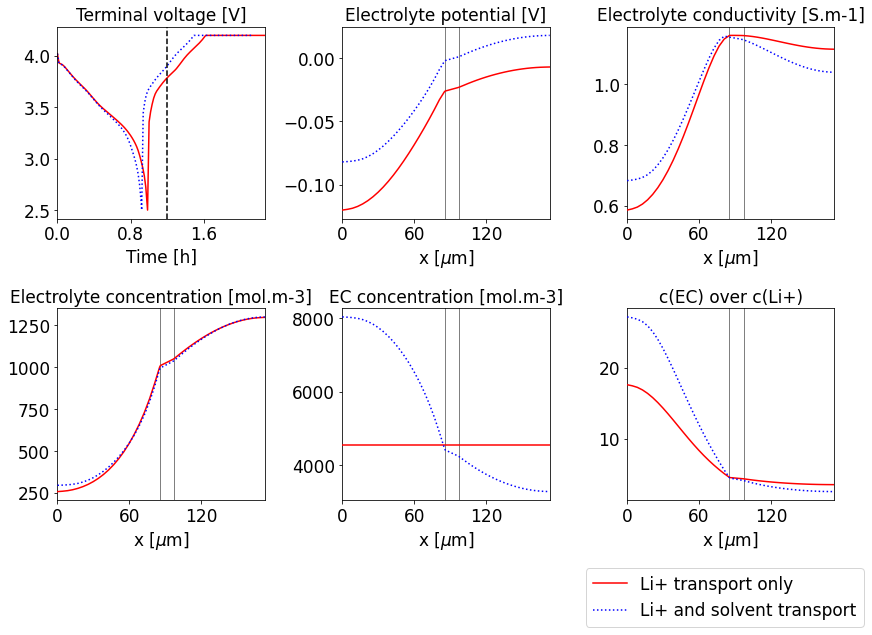

In [60]:
label = ["Li+ transport only","Li+ and solvent transport",  ]
output_variables3 = [
    "Terminal voltage [V]",
    #"Discharge capacity [A.h]",
    "Electrolyte potential [V]",
    #"Electrolyte current density [A.m-2]",
    'Electrolyte conductivity [S.m-1]',
    "Electrolyte concentration [mol.m-3]",
    "EC concentration [mol.m-3]",
    "c(EC) over c(Li+)",
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol], 
    output_variables3,label,
    variable_limits='tight',time_unit='hours',n_rows=2,
    figsize = (12,9)) #     spatial_unit='mm',
quick_plot.dynamic_plot();
quick_plot.plot(1.2)
quick_plot.fig.savefig(
    "D:/OneDrive - Imperial College London/PhD Study/Imperial Study/Meeting and Discussion/Academic meeting/Advanced Battery Power conference 2023/" 
    +
    "overview.png", 
    dpi=600)

In [61]:
label = [model.options["solvent diffusion"] for model in Models]
output_variables3 = [
    "Terminal voltage [V]",   
    "Discharge capacity [A.h]",
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    "Li+ flux [mol.m-2.s-1]",
    "EC flux [mol.m-2.s-1]",
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol], 
    output_variables3,label,
    variable_limits='fixed',time_unit='hours',n_rows=2,
    figsize = (12,8)) #     spatial_unit='mm',
quick_plot.dynamic_plot();
#quick_plot.plot(0.5)
#quick_plot.fig.savefig(BasicPath + Target+"t_0+_three_cases.png", dpi=600)
#quick_plot.create_gif(
#    number_of_images=10, duration=2,output_filename=BasicPath + Target+"concentration and flux.gif")

interactive(children=(FloatSlider(value=0.0, description='t', max=2.269087711061189, step=0.02269087711061189)…

In [62]:
label = [model.options["solvent diffusion"] for model in Models]
output_variables3 = [
    #"Terminal voltage [V]",   
    "EC flux [mol.m-2.s-1]",
    "EC flux by diffusion [mol.m-2.s-1]",
    "EC flux by migration [mol.m-2.s-1]",
    "EC flux by Li+ [mol.m-2.s-1]",
    "Li+ flux [mol.m-2.s-1]",
    "Li+ flux by diffusion [mol.m-2.s-1]",
    "Li+ flux by migration [mol.m-2.s-1]",
    "Li+ flux by solvent [mol.m-2.s-1]",      
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol], 
    output_variables3,label,
    variable_limits='fixed',time_unit='hours',n_rows=2,
    figsize = (12,6)) #     spatial_unit='mm',
quick_plot.dynamic_plot();
#quick_plot.plot(0.5)
#quick_plot.fig.savefig(BasicPath + Target+"t_0+_three_cases.png", dpi=600)
#quick_plot.create_gif(
#    number_of_images=10, duration=2,output_filename=BasicPath + Target+"flux contribution.gif")

interactive(children=(FloatSlider(value=0.0, description='t', max=2.269087711061189, step=0.02269087711061189)…

In [63]:
font = {'family' : 'DejaVu Sans','size':19}
mpl.rc('font', **font)
label = [model.options["solvent diffusion"] for model in Models]
output_variables3 = [
    "Electrolyte concentration",
    "Minus div Li+ flux",
    "Li+ source term",
    "Li+ source term refill",
    "Minus div Li+ flux by diffusion",
    "Minus div Li+ flux by migration",
    "Minus div Li+ flux by solvent",
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol], 
    output_variables3,label,
    variable_limits='fixed',time_unit='hours',n_rows=3,
    figsize = (12,12)) #     spatial_unit='mm',
quick_plot.dynamic_plot();
#quick_plot.create_gif(
#    number_of_images=10, duration=2,output_filename=BasicPath + Target+"Li+ rhs contribution.gif")

interactive(children=(FloatSlider(value=0.0, description='t', max=2.269087711061189, step=0.02269087711061189)…

In [64]:
label = [model.options["solvent diffusion"] for model in Models]
output_variables3 = [
    "EC concentration",
    "EC source term (SEI)",
    "EC source term refill",
    "Minus div EC flux",
    "Minus div EC flux by diffusion",
    "Minus div EC flux by migration",
    "Minus div EC flux by Li+",
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol], 
    output_variables3,label,
    variable_limits='tight',time_unit='hours',n_rows=3,
    figsize = (12,12)) #     spatial_unit='mm',
quick_plot.dynamic_plot();
#quick_plot.create_gif(
#    number_of_images=10, duration=2,output_filename=BasicPath + Target+"EC rhs contribution.gif")

interactive(children=(FloatSlider(value=0.0, description='t', max=2.269087711061189, step=0.02269087711061189)…